<a href="https://colab.research.google.com/github/james-t-little/cnn_diss_repo/blob/main/help.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import random
import PIL
from google.colab import drive
from PIL import Image, ImageOps
from tqdm import tqdm
from collections import Counter
import tensorflow as tf
import matplotlib.pyplot as plt

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
drive.mount('/content/drive')

path = '/content/drive/MyDrive/dissertation_seg_data'

input_path = os.path.join(path,"input_resize_patches/")

mask_path = os.path.join(path,"mask_resize_patches/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Image size that we are going to use
IMG_SIZE = 512
# Our images are RGB (3 channels)
N_CHANNELS = 3
# Scene Parsing has 150 classes + `not labeled`
N_CLASSES = 4

In [4]:
def parse_image(image_path: str) -> dict:
    mask_path = tf.strings.regex_replace(image_path, "image", "labels")
    mask_path = tf.strings.regex_replace(mask_path, "input_resize_patches", "mask_resize_patches")

    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels = 1)
    mask = tf.where(mask == 255, np.dtype('uint8').type(0), mask)

    return {'image' : image, 'segmentation_mask': mask}

In [5]:
train_dataset = tf.data.Dataset.list_files(input_path + "*.png")

for filename in train_dataset.take(10):
  print(filename.numpy().decode('utf-8'))

train_dataset = train_dataset.map(parse_image)

for image in train_dataset.take(10):
    print(image['image'], image['segmentation_mask'],)

/content/drive/MyDrive/dissertation_seg_data/input_resize_patches/paris275_image_resize_patch_2.png
/content/drive/MyDrive/dissertation_seg_data/input_resize_patches/paris593_image_resize_patch_1.png
/content/drive/MyDrive/dissertation_seg_data/input_resize_patches/paris155_image_resize_patch_5.png
/content/drive/MyDrive/dissertation_seg_data/input_resize_patches/top_potsdam_6_11_image_resize_patch_7.png
/content/drive/MyDrive/dissertation_seg_data/input_resize_patches/paris26_image_resize_patch_4.png
/content/drive/MyDrive/dissertation_seg_data/input_resize_patches/chicago22_image_resize_patch_1.png
/content/drive/MyDrive/dissertation_seg_data/input_resize_patches/chicago187_image_resize_patch_4.png
/content/drive/MyDrive/dissertation_seg_data/input_resize_patches/paris179_image_resize_patch_7.png
/content/drive/MyDrive/dissertation_seg_data/input_resize_patches/berlin46_image_resize_patch_3.png
/content/drive/MyDrive/dissertation_seg_data/input_resize_patches/chicago490_image_resize_

In [6]:
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    
    input_image = tf.cast(input_image, tf.float32) / 255.0
    
    return input_image, input_mask

def load_image_train(datapoint: dict) -> tuple:
    
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

@tf.function
def load_image_test(datapoint: dict) -> tuple:

    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [7]:
BATCH_SIZE = 5

# for reference about the BUFFER_SIZE in shuffle:
# https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle
BUFFER_SIZE = 1000

dataset = {"train": train_dataset}

# -- Train Dataset --#
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=47)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)

print(dataset['train'])

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None))>


In [8]:
def display_sample(display_list):
    """Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [11]:
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

TypeError: ignored

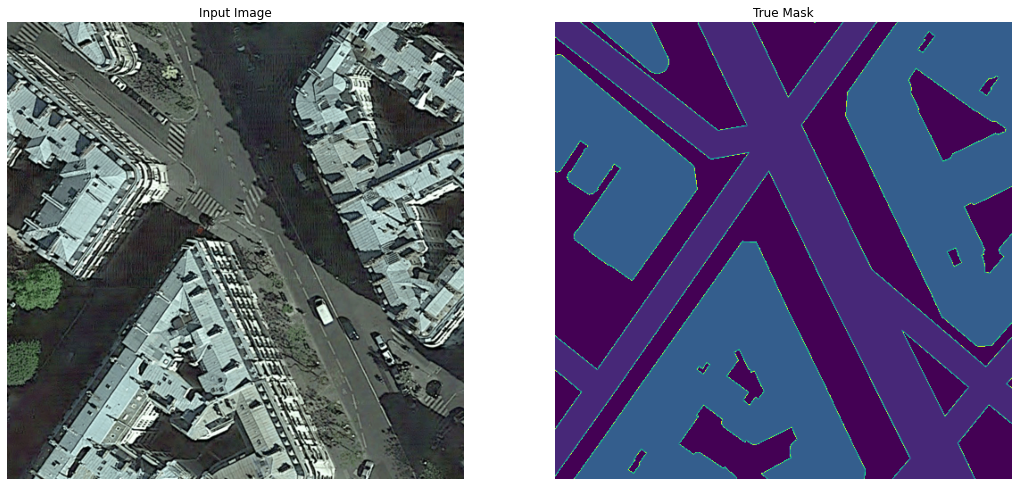

In [12]:
display_sample([sample_image[0], sample_mask[0]])